In [1]:
!pip3 install torch 
!pip3 install torchvision
!pip3 install tqdm

In [0]:
import torchvision.models as models
vgg = models.vgg16(pretrained=True)
import torch
import torchvision
import os
import gzip
import tarfile
import gc
from IPython.core.ultratb import AutoFormattedTB

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm


## Import the Images

In [3]:
from PIL import Image
import io
 
from google.colab import files
 
load_and_normalize = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
])
 
print('Upload Content Image')
file_dict = files.upload()
content_image = Image.open(io.BytesIO(file_dict[next(iter(file_dict))]))
content_image = load_and_normalize(np.array(content_image)).unsqueeze(0)
 
print('\nUpload Style Image')
file_dict = files.upload()
style_image = Image.open(io.BytesIO(file_dict[next(iter(file_dict))]))
style_image = load_and_normalize(np.array(style_image)).unsqueeze(0)

Upload Content Image


Saving content.png to content (5).png

Upload Style Image


Saving style.png to style (3).png


##The VGG network
- follow the layout from Gatys et. al. (https://arxiv.org/pdf/1508.06576v2.pdf)

In [0]:
class VGGIntermediate(nn.Module):
  def __init__(self, requested=[]):
    super(VGGIntermediate, self).__init__()
    
    self.intermediates = {}
    self.vgg = models.vgg16(pretrained=True).features.eval()
    for i, m in enumerate(self.vgg.children()):
        if isinstance(m, nn.ReLU):   # we want to set the relu layers to NOT do the relu in place. 
          m.inplace = False          # the model has a hard time going backwards on the in place functions. 
          
        if i in requested:
          def curry(i):
            def hook(module, input, output):
              self.intermediates[i] = output
            return hook
          m.register_forward_hook(curry(i))
    
  def forward(self, x):
    self.vgg(x)  
    return self.intermediates

##Create Content loss and Style Loss functions
- The loss function is the key to getting this to work. Follow the documentation at https://pytorch.org/tutorials/advanced/neural_style_tutorial.html#sphx-glr-download-advanced-neural-style-tutorial-py 

In [0]:
class ContentLoss(nn.Module):
  def __init__(self,target,):
    super(ContentLoss, self).__init__()
    #detach the target content from the tree and dynamically computes the  gradient
    self.target = target.detach()
    
  def forward(self,input):
    self.loss = F.mse_loss(input, self.target) #F is our functional we imported earlier
    return self.loss #return self.loss to allow us to get loss immediately upon calling

In [0]:
#Now write a class to calculate the style loss. first write the gram_matrix funciton

def gram_matrix(input):
  a,b,c,d = input.size() #a = batch size = 1, b is number of feature maps, (c,d) are the dimensions
  features = input.view(a*b, c*d) #This resizes F
  G = torch.mm(features, features.t()) #This does the gram product; we return the normalized version
  return G.div(a*b*c*d)

class StyleLoss(nn.Module):
  def __init__(self,target_feature):
    super(StyleLoss,self).__init__()
    self.target = gram_matrix(target_feature).detach() #Style Loss depends on the gram matrix
  
  def forward(self,input):
    G = gram_matrix(input)
    self.loss = F.mse_loss(G, self.target)
    return self.loss #allows us to gain loss quickly

## Prep to run model and run the image VGG network on Content and Style
- activate style and loss layers, following Sinomyen et al https://arxiv.org/pdf/1409.1556.pdf
- initialize our generated image content and style layers

In [0]:
vgg_names = ["conv1_1", "relu1_1", "conv1_2", "relu1_2", "maxpool1", 
             "conv2_1", "relu2_1", "conv2_2", "relu2_2", "maxpool2",
             "conv3_1", "relu3_1", "conv3_2", "relu3_2", "conv3_3", "relu3_3","maxpool3",
             "conv4_1", "relu4_1", "conv4_2", "relu4_2", "conv4_3", "relu4_3","maxpool4",
             "conv5_1", "relu5_1", "conv5_2", "relu5_2", "conv5_3", "relu5_3","maxpool5"]


layer_dict = {name: i for i, name in enumerate(vgg_names)}

vgg = VGGIntermediate(requested=layer_dict.values()) #create a dictionary of activation layers; numbers intake
vgg.cuda()
content_layer =  vgg(content_image.cuda())
style_layer =  vgg(style_image.cuda())

content_activation = content_layer[layer_dict["conv4_2"]]
style_activation = [style_layer[layer_dict["conv{}_1".format(i)]] for i in range(1,6)]

## Create our Optimizer, initialize our generated image, and optimize

In [14]:

gen_image = content_image.clone() #need .clone() to make sure the content image does not change

optimizer = optim.Adam([gen_image.requires_grad_()],lr = .1) # content_image is the 3x224x224 torch.Tensor

#lastly, initialize alpha, beta
alpha = 1 #increasing this puts more emphasis on the content not the style
beta = 10000000 #increasing this puts more emphasis on the style, not the content

epochs = 1000
loop = tqdm(total=epochs, position=0, leave = False)
for epoch in range(epochs):
  
  #define gen_layer
  
  gen_layer = vgg(gen_image.cuda()) 
  
  #def gen_content and gen_layer
  gen_content = gen_layer[layer_dict["conv4_2"]]
  gen_style = [gen_layer[layer_dict["conv{}_1".format(i)]] for i in range(1,6)]
  
  #calculate content and style loss
  cont_loss = ContentLoss(content_activation)
  
  style_loss = []
  for i in range(len(style_activation)):
    style_loss.append(StyleLoss(style_activation[i]))
 
  
  optimizer.zero_grad()  #reset the gradients
  
  cont_loss_num = cont_loss.forward(gen_content)
  style_loss_num = sum(style_loss[i].forward(gen_style[i]) for i in range(len(style_loss)))

  loss = alpha*cont_loss_num + beta*style_loss_num
  loss.backward(retain_graph = True)
  
  loop.update(1)
  loop.set_description('epoch:{}, loss:{:.4f}'.format(epoch, loss.item())) #.item return the float
  
  optimizer.step()
  
  
  





epoch:999, loss:838.5692: 100%|██████████| 1000/1000 [01:20<00:00, 12.50it/s]

##Show the Images

In [0]:
inverse_normalized = transforms.Normalize(mean=[-0.485/.299, -0.456/.224, -0.406/.255],
                                 std=[1/.229, 1/.224, 1/.225]) #add back in our scaled mean and inverse our standard deviation

def imshow(tensor, title = ""):
  image = tensor.detach().cpu().clone()
  image = image.squeeze(0)
  image = inverse_normalized(image) #remove the faker batch dimension
  image = image.clamp(0,1)
  plt.imshow(image.numpy().transpose(1,2,0))
  plt.title(title)
  plt.axis("off")

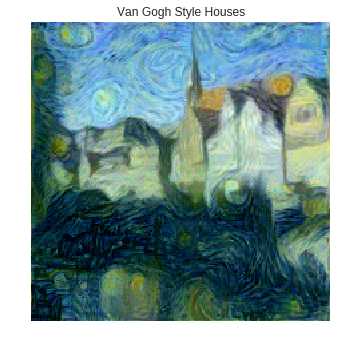

In [16]:
imshow(gen_image, "Van Gogh Style Houses")